# Excess death rate calculations

This document calculates the excess date rates associated with treatment for stroke. It calculates separate excess death rates for these three populations:

| Patient group | Excess death rate |
| --- | --- |
| nLVO with IVT | __1.1%__ |
| LVO with IVT | __3.4%__ |
| LVO with MT | __4.0%__ |

where nLVOs are non-Large Vessel Occlusions, LVOs are Large Vessel Occlusions, IVT is intravenous thrombolysis, and MT is mechanical thrombectomy.

## Plain English summary 

Treating a stroke with thrombolysis or thrombectomy has the potential to remove the cause of the stroke, reduce the symptoms, and cause a better outcome after the stroke than if the patient had received no treatment. However, the treatments have the drawback of a small risk of death directly caused by the treatment.

We want to include this risk of death in the outcome model to make sure the results it gives are as true to life as possible.

To find the risk of excess death for each combination of occlusion and treatment types, we look at clinical trial data where the death rates are recorded in groups of people who received treatment and groups of people who received no treatment.

## Data sources

Full reference information is given at the end of this document.

| Source | Useful data |
| --- | --- | 
| Alteplase meta-analysis (Emberson et al. 2014) | Numbers of patients grouped by NIHSS score, whether or not they received thrombolysis, and whether or not they died. |
| HERMES thrombectomy meta-analysis (Goyal et al. 2016) | Mortality rate with MT, average time to MT, and mRS distributions for a population of patients with LVO who did not receive thrombectomy. |
| Recanalisation meta-analysis (Hui et al. 2020) | 75% rate of successful recanalisation with MT. |
| SSNAP | Pre-stroke mRS distribution for patients with LVO. |

As usual we assign nLVO to patients with an NIHSS of 10 or below following the RACE scale (de la Ossa Herrero et al. 2013).

## Method

For IVT, the basic steps are:
+ Calculate the death rate for the group who received thrombolysis
+ Calculate the death rate for the group who did not receive thrombolysis
+ Take the difference. This is the excess death rate.

For MT, the method is more complicated because the same data is not available. The steps are:
+ Find a reference data point where both the death rate and time to treatment are known. We use the mean time to treatment and the mortality rate from the HERMES meta-analysis (Goyal et al. 2016).
+ Define an excess death rate.
+ Apply these excess deaths uniformly to the pre-stroke and no-treatment mRS distributions.
+ Combine these mRS distributions to find the distribution for treatment at time zero and for treatment at the time of no effect.
+ Take the probability of being alive (mRS < 6) in both distributions. Convert them to log-odds.
+ Assume that log-odds falls steadily with time. This follows the methodolody in the alteplase meta-analysis (Emberson et al. 2014). Calculate the log-odds at the treatment time.
+ Compare this log-odds at the treatment time with the target value.
+ Adjust the excess death rate and repeat these steps until there is no difference between the calculated and target log-odds at the treatment time.

## Notebook setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize  # optimise MT excess death rate

## Intravenous thrombolysis

![Summary image for calculating excess deaths for IVT. 1. Calculate excess deaths for nLVO patients. Table of patient numbers from Emberson et al. 2014. Excess deaths is the difference in percentages. → Excess death is 1.1%. 2. Calculate excess deaths for LVO patients. Table of patient numbers from Emberson et al. 2014. Excess deaths is the difference in percentages. → Excess death is 3.4%.](./images/data_sources_excess-death-ivt.png)

In [2]:
rows = ['Number of patients', 'Deaths']
headings = ['Given IVT', 'No treatment']

### nLVO patients

Make a copy of the data from the table:

In [3]:
df_nlvo = pd.DataFrame(
    [[345, 1281, 321, 1252],
     [3, 20, 0, 5]],
    index=rows,
    columns=pd.MultiIndex.from_tuples([
        ('Given IVT', 'NIHSS_0-4'), ('Given IVT', 'NIHSS_5-10'),
        ('No treatment', 'NIHSS_0-4'), ('No treatment', 'NIHSS_5-10'),
    ])
)

# Sum the NIHSS 0-4 and NIHSS 5-10 columns to find NIHSS 0-10:
for row in rows:
    for head in headings:
        df_nlvo.loc[row, (head, 'NIHSS_0-10')] = (
            df_nlvo.loc[row, [(head, 'NIHSS_0-4'), (head, 'NIHSS_5-10')]].sum())

# Sort the columns:
df_nlvo = df_nlvo[headings]

In [4]:
df_nlvo

Given IVT                       No treatment             \
                   NIHSS_0-4 NIHSS_5-10 NIHSS_0-10    NIHSS_0-4 NIHSS_5-10   
Number of patients       345       1281     1626.0          321       1252   
Deaths                     3         20       23.0            0          5   

                               
                   NIHSS_0-10  
Number of patients     1573.0  
Deaths                    5.0

Calculate the death rates from the table:

In [5]:
percdeath_nlvo_givenivt = 100.0 * (
    df_nlvo['Given IVT']['NIHSS_0-10']['Deaths'] /
    df_nlvo['Given IVT']['NIHSS_0-10']['Number of patients']
)

percdeath_nlvo_notreat = 100.0 * (
    df_nlvo['No treatment']['NIHSS_0-10']['Deaths'] /
    df_nlvo['No treatment']['NIHSS_0-10']['Number of patients']
)

excess_deaths_nlvo = percdeath_nlvo_givenivt - percdeath_nlvo_notreat

Show the excess death rate:

In [6]:
print(f'Death rate for "Given IVT":    {percdeath_nlvo_givenivt:.3f}%')
print(f'Death rate for "No treatment": {percdeath_nlvo_notreat:.3f}%')
print(f'Excess death rate:             {excess_deaths_nlvo:.3f}%')

Death rate for "Given IVT":    1.415%
Death rate for "No treatment": 0.318%
Excess death rate:             1.097%


### LVO patients

Repeat the same method as for nLVO patients.

Make a copy of the data from the table:

In [7]:
df_lvo = pd.DataFrame(
    [[794, 662, 309, 808, 671, 313],
     [23, 24, 21, 1, 5, 2]],
    index=rows,
    columns=pd.MultiIndex.from_tuples([
        ('Given IVT', 'NIHSS_11-15'), ('Given IVT', 'NIHSS_16-21'), ('Given IVT', 'NIHSS_>=22'),
        ('No treatment', 'NIHSS_11-15'), ('No treatment', 'NIHSS_16-21'), ('No treatment', 'NIHSS_>=22'),
    ])
)

# Sum the NIHSS 11-15, NIHSS 16-21 and NIHSS >=22 columns to find NIHSS >=11:
for row in rows:
    for head in headings:
        df_lvo.loc[row, (head, 'NIHSS_>=11')] = (
            df_lvo.loc[row, [(head, 'NIHSS_11-15'), (head, 'NIHSS_16-21'), (head, 'NIHSS_>=22')]].sum())

# Sort the columns:
df_lvo = df_lvo[headings]

In [8]:
df_lvo

Given IVT                                   No treatment  \
                   NIHSS_11-15 NIHSS_16-21 NIHSS_>=22 NIHSS_>=11  NIHSS_11-15   
Number of patients         794         662        309     1765.0          808   
Deaths                      23          24         21       68.0            1   

                                                      
                   NIHSS_16-21 NIHSS_>=22 NIHSS_>=11  
Number of patients         671        313     1792.0  
Deaths                       5          2        8.0

Calculate the death rates from the table:

In [9]:
percdeath_lvo_givenivt = 100.0 * (
    df_lvo['Given IVT']['NIHSS_>=11']['Deaths'] /
    df_lvo['Given IVT']['NIHSS_>=11']['Number of patients']
)

percdeath_lvo_notreat = 100.0 * (
    df_lvo['No treatment']['NIHSS_>=11']['Deaths'] /
    df_lvo['No treatment']['NIHSS_>=11']['Number of patients']
)

excess_deaths_lvo = percdeath_lvo_givenivt - percdeath_lvo_notreat

Show the excess death rate:

In [10]:
print(f'Death rate for "Given IVT":    {percdeath_lvo_givenivt:.3f}%')
print(f'Death rate for "No treatment": {percdeath_lvo_notreat:.3f}%')
print(f'Excess death rate:             {excess_deaths_lvo:.3f}%')

Death rate for "Given IVT":    3.853%
Death rate for "No treatment": 0.446%
Excess death rate:             3.406%


## Mechanical thrombectomy

![Summary image for calculating excess deaths from MT. 1. Find reference data point. The average MT treatment time is 285 minutes and the death rate of patients given MT is 15.3%. This gives a probability that mRS is less than 6 of 84.7%. Convert this probability to log-odds. The log-odds of mRS being less than 6 when MT is given at 285 minutes is 1.709. → log-odds reference = 1.709. 2. Define time-zero distribution. Calculate two distributions: Full-effect data: pre-stroke data with excess deaths. No-effect data: no-treatment data with excess deaths. Combine 75% of the full-effect data with 25% of the no-effect data to make the time-zero data. 3. Method for finding excess deaths: Set the excess death value e.
As above, use these excess deaths to calculate: The full-effect data, The no-effect-time data, The time-zero data. Take the probability that mRS is less than 6 in the time-zero and the no-effect-time distributions. Convert the probabilities to log-odds. Plot the two log-odds values and treatment times and connect the points with a straight line. How close is the straight line to the reference point? These steps can be repeated with different values of excess death e until the line passes exactly through the reference data point. Using an optimiser function, we find the best e=4.00%. → Excess death is 4.0%.](./images/data_sources_excess-death-mt.png)

### Define functions for the MT calculations

The following functions convert one or more values from probability into log-odds and back:

In [11]:
def convert_prob_to_logodds(p):
    return np.log(p / (1.0 - p))

In [12]:
def convert_logodds_to_prob(l):
    return np.exp(l) / (1.0 + np.exp(l))

The following two functions are defined because the calculations will be needed very many times to fine-tune the value of excess death rate.

The following function adjusts the probabilities for pre-stroke and no-treatment populations by accounting for excess deaths:

In [13]:
def calculate_logodds_with_excess_deaths(p_pre, p_not, ed):
    """
    Find logodds at time zero and time of no effect.

    Add the excess deaths into the pre-stroke and no-treatment
    distributions. Then calculate a weighted sum of the two dists.
    Convert the resulting probabilities to log-odds.

    Inputs
    ------
    p_pre - float or np.array. Pre-stroke probability.
    p_not - float or np.array. No-treatment probability.
    ed    - float. Excess death rate.

    Returns
    -------
    l_t0  - float or np.array. Log-odds at time zero.
    l_tne - float or np.array. Log-odds at no-effect time.
    """
    # Weight pre-stroke probability by excess deaths:
    p_pre_deaths = p_pre * (1.0 - ed)
    # Weight no-treatment probability by excess deaths:
    p_tne = p_not * (1.0 - ed)
    # Calculate new time-zero-treatment probability by
    # combining the new pre-stroke and no-treatment probs:
    p_t0 = (0.75 * p_pre_deaths) + (0.25 * p_tne)
    
    # Convert time-zero and time-of-no-effect probs to logodds:
    l_t0 = convert_prob_to_logodds(p_t0)
    l_tne = convert_prob_to_logodds(p_tne)
    return l_t0, l_tne

The following function first uses the previous function to find the probabilities for treatment at time zero and at the time of no effect. It then uses those end points to find the log-odds at the target treatment time.

In [14]:
def calculate_logodds_t_target(ed, p_pre, p_not, tne, t0, t_target):
    """
    Calculate logodds at target time from scratch.

    Find the log-odds for treatment at time zero and at the time of
    no-effect. Connect the two points with a straight line. Find
    the value of log(odds) along this line at the target time.
    
               ^
               |  (t0, l_t0)
               | x__
    log(odds)  |    \__
               |       \__   (tne, l_tne)
               |          \_x     
               +------------------>
                     Time

    Inputs
    ------
    ed       - float. Excess death rate.
    p_pre    - float or np.array. Pre-stroke probability.
    p_not    - float or np.array. No-treatment probability.
    t_ne     - float. Time of no effect.
    t0       - float. Time zero.
    t_target - float. Target treatment time.

    Returns
    -------
    l_t_target - float or np.array. Log-odds at target treatment time.
    """
    # First add excess deaths into the pre-stroke and no-treatment
    # probabilities. Take their weighted sum to find the time-zero
    # probabilities. Convert the time-zero treatment and no-effect
    # probabilities into log-odds.
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)

    # Treat the two log-odds values as two points to be connected
    # with a straight line. Find an equation for the line based on
    # its slope and y-intercept.
    slope = (l_tne - l_t0) / (tne - t0)
    y_intercept = l_t0

    # Use this line equation to find the log-odds at the chosen
    # treatment time.
    l_t_target = (slope * t_target) + y_intercept
    return l_t_target

### Gather reference data

Define times in hours:

In [15]:
t0 = 0.0   # time zero
tne = 8.0  # time of no effect
# Average MT treatment time:
t_target = (285.0 / 60.0)  # from the treatment time table.

Gather the probabilities of being alive (mRS less than 6) in the pre-stroke and no-treatment distributions:

In [16]:
# Store mRS dists in this dictionary:
mrs_dists = dict()
mrs_dists['pre_stroke_lvo'] = np.array([0.4179, 0.1430, 0.1184, 0.1642, 0.1138, 0.0427, 0.0000])
mrs_dists['no_treatment_lvo'] = np.array([0.0500, 0.0790, 0.1360, 0.1640, 0.2470, 0.1350, 0.1890])

# Convert the mRS distributions to cumulative mRS distributions:
mrs_dists_cumsum = dict()
for key, val in zip(mrs_dists.keys(), mrs_dists.values()):
    mrs_dists_cumsum[key] = np.cumsum(mrs_dists[key])

# Probabilities of mRS < 6 in pre-stroke and no-treatment distributions:
p_pre = mrs_dists_cumsum['pre_stroke_lvo'][5]
p_not = mrs_dists_cumsum['no_treatment_lvo'][5]

In [17]:
print(f'Probability of mRS < 6 for pre-stroke:   {p_pre}')
print(f'Probability of mRS < 6 for no-treatment: {p_not}')

Probability of mRS < 6 for pre-stroke:   1.0
Probability of mRS < 6 for no-treatment: 0.811


Target probability of being alive (mRS less than 6) at average MT treatment time:

In [18]:
# Probability of death:
p_death_mt = 97.0 / 633.0  # from the mortality rate table.

# Flip this for probability of being alive:
p_target = 1.0 - p_death_mt

Check that the target probability is between the starting and ending probabilities:

In [19]:
p_pre, p_not, p_target

(1.0, 0.811, 0.8467614533965244)

Convert the target probability into log-odds at the average MT treatment time:

In [20]:
l_target = convert_prob_to_logodds(p_target)

In [21]:
l_target

1.7094231825674187

Check that the target log-odds is correct by converting it back to probability. The result of the following function should match `p_target`.

In [22]:
convert_logodds_to_prob(l_target)

0.8467614533965244

### When excess deaths are zero, what is the mortality rate at 285 minutes?

Expect this value to be a bit lower than the target 15.3% from the paper.

In [23]:
l_target_ed0 = calculate_logodds_t_target(0.0, p_pre, p_not, tne, t0, t_target)
p_target_ed0 = convert_logodds_to_prob(l_target_ed0)

print(f'Mortality at {t_target} hours: {1.0 - p_target_ed0:.2%}')

Mortality at 4.75 hours: 11.05%


### Try various excess death rates

Calculate the straight-line fit for various excess death rates and plot them as we go along.

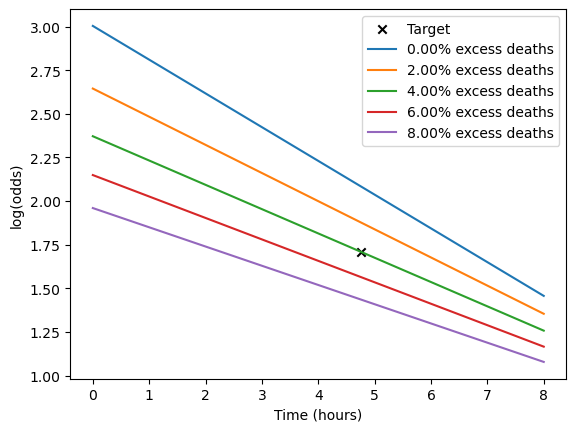

In [24]:
# First mark the target log-odds at the treatment time:
plt.scatter(t_target, l_target, label='Target', marker='x', color='k')

for ed in np.arange(0.00, 0.10, 0.02):
    # Find endpoints of the straight line for this excess deaths value:
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)
    # Plot the straight line fit:
    plt.plot(
        [t0, tne],
        [l_t0, l_tne],
        label=f'{ed:.2%} excess deaths'
    )
plt.legend()
plt.ylabel('log(odds)')
plt.xlabel('Time (hours)')
plt.show()

### Optimize the value of "excess deaths"

Find the best value of "excess deaths" by using an optimiser function to try lots of different values. The "best" value is the one that gives the smallest difference between the target and the calculated log-odds at the treatment time. The optimiser will keep adjusting the value until the difference is as small as possible.

This function returns the difference between the calculated value and the target:

In [25]:
def calculate_difference_logodds_t_target(ed, args):
    """Calculate log-odds and find difference from target value."""
    l_t_target = calculate_logodds_t_target(ed, *args[1:])
    return np.abs(args[0] - l_t_target)

In [26]:
results = minimize(
    calculate_difference_logodds_t_target,  # Result from this func.
    0.03,                                   # Initial guess.
    args = [l_target, p_pre, p_not, tne, t0, t_target],  # Constants.
    method='Nelder-Mead'                    # Good when abs() in func.
)

# Save the optimized excess deaths value:
ed_opt = results.x[0]

# View full results:
results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.00033718804324145424
             x: [ 4.003e-02]
           nit: 9
          nfev: 18
 final_simplex: (array([[ 4.003e-02],
                       [ 4.013e-02]]), array([ 3.372e-04,  3.890e-04]))

Resulting excess deaths value:

In [27]:
ed_opt

0.040031250000000004

Check that this excess death value is sensible by plotting its straight line fit:

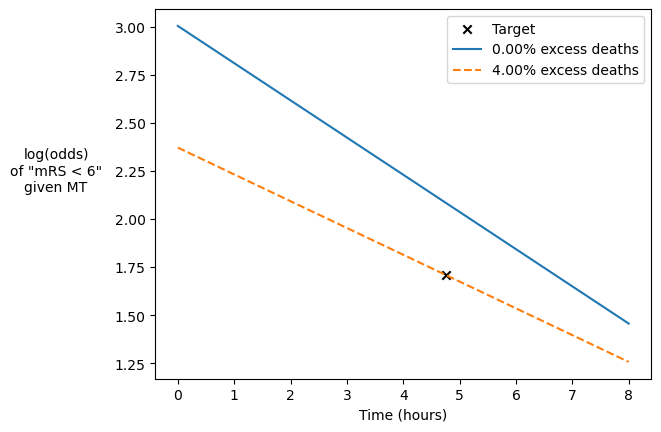

In [28]:
fig, ax = plt.subplots()
ax.scatter(t_target, l_target, label='Target', marker='x', color='k')

for e, ed in enumerate([0.00, ed_opt]):
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)
    ax.plot(
        [t0, tne],
        [l_t0, l_tne],
        label=f'{ed:.2%} excess deaths',
        linestyle='-' * (e + 1)
    )

ax.set_ylabel('log(odds)\nof "mRS < 6"\ngiven MT', rotation=0)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_xlabel('Time (hours)')
plt.legend()
plt.savefig('./images/excess_deaths_mt_fit.png', bbox_inches='tight')
plt.show()

## Resulting excess death rates

In [29]:
print(f'nLVO with IVT: {excess_deaths_nlvo:.3f}%')
print(f'LVO with IVT:  {excess_deaths_lvo:.3f}%')
print(f'LVO with MT:   {100.0*ed_opt:.3f}%')

nLVO with IVT: 1.097%
LVO with IVT:  3.406%
LVO with MT:   4.003%
